## Load features

In [155]:
import pandas as pd
import numpy as np
import pickle
import time

In [7]:
src = 'feature/'
files = ['seller_info_format_feature_3.csv', 
         'user_info_format_feature_3.csv', 
         'user_seller_info_format_feature_3.csv']
# files = ['sellerInfo_Features_3.pkl', 
#          'userInfo_Features_3.pkl', 
#          'userSellerInfo_Features_3.pkl']

### Load preprossed data and labels

In [16]:
seller = pd.read_csv(src+files[0], index_col=0)
user = pd.read_csv(src+files[1], index_col=0)
user_seller = pd.read_csv(src+files[2], index_col=0)

In [210]:
labels = pd.read_csv('data/data_format1/train_format1.csv')

In [181]:
alitest = pd.read_csv('data/data_format1/test_format1.csv')
alitest.drop(columns='prob', inplace=True)

In [93]:
seller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4995 entries, 0 to 4994
Data columns (total 24 columns):
seller_id                    4995 non-null int64
sellerTotalAction_0          4995 non-null float64
sellerTotalAction_1          4995 non-null float64
sellerTotalAction_2          4995 non-null float64
sellerTotalAction_3          4995 non-null float64
sellerTotalAction            4995 non-null float64
sellerTotalAction_0_ratio    4995 non-null float64
sellerTotalAction_1_ratio    4995 non-null float64
sellerTotalAction_3_ratio    4995 non-null float64
item_number                  4995 non-null float64
cat_number                   4995 non-null float64
brand_number                 4995 non-null float64
item_ratio                   4995 non-null float64
cat_ratio                    4995 non-null float64
brand_ratio                  4995 non-null float64
seller_peopleNum_0           4995 non-null float64
seller_peopleNum_1           4995 non-null float64
seller_peopleNum_2          

In [24]:
user['gender'] = user['gender'].astype('int8')

### Join tables and sperate features alone

In [205]:
all_data = pd.merge(user_seller, user, on='user_id')
all_data = pd.merge(all_data, seller, on='seller_id')

In [206]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Columns: 125 entries, user_id to repeatBuy_peopleNumber
dtypes: float64(112), int64(12), int8(1)
memory usage: 498.6 MB


In [217]:
train_data = pd.merge(all_data, 
                    labels, 
                    left_on=['user_id', 'seller_id'], 
                    right_on=['user_id', 'merchant_id'])

In [218]:
test_data = pd.merge(alitest, 
                     all_data, 
                     left_on=['user_id', 'merchant_id'], 
                     right_on=['user_id', 'seller_id'])

In [219]:
train_data = train_data.drop(columns=['merchant_id'])
test_data = test_data.drop(columns=['merchant_id'])
train_data.to_csv(src+'train_data_merged.csv')
test_data.to_csv(src+'test_data_merged.csv')

In [116]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261477 entries, 0 to 261476
Columns: 125 entries, user_id to repeatBuy_peopleNumber
dtypes: float64(112), int64(12), int8(1)
memory usage: 249.6 MB


In [220]:
train_features = train_data.drop(columns=['user_id', 'seller_id', 'label'])
test_features = test_data.drop(columns=['user_id', 'seller_id'])

In [118]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 0 to 260863
Columns: 123 entries, userSellerAction_0 to repeatBuy_peopleNumber
dtypes: float64(112), int64(10), int8(1)
memory usage: 245.0 MB


## Create trainset and testset

In [46]:
from sklearn.model_selection import train_test_split

In [221]:
X_train, X_test, y_train, y_test = train_test_split(train_features, 
                                                    train_data['label'], 
                                                    test_size=0.33, 
                                                    random_state=42)

## Train classifiers

In [139]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

### Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression

In [189]:
lr = LogisticRegression(penalty='l2', 
                        dual=False, 
                        tol=0.0001, 
                        C=1.0, 
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        class_weight=None,
                        random_state=None, 
                        solver='lbfgs', 
                        max_iter=100, 
                        multi_class='ovr', 
                        verbose=0, 
                        warm_start=False,
                        n_jobs=None)

In [222]:
start = time.time()
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
end = time.time()
print('The program took %s seconds.' % (end-start))

0.938631136305555
The program took 2.7695624828338623 seconds.


C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### Train for ali testset

In [79]:
lr.classes_

array([0, 1], dtype=int64)

In [223]:
lr.fit(train_features, train_data['label'])
lr.score(train_features, train_data['label'])

C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9388225282139352

In [227]:
test_features = test_features.drop(columns=['prob'])

In [228]:
prob = lr.predict_proba(test_features)

In [229]:
alitest.drop(columns='prob', inplace=True)
alitest.insert(2, 'prob', prob[:,1])
alitest.to_csv('data/submission_1229_logireg.csv', index=False)

### SVM

In [140]:
from sklearn.svm import LinearSVC

In [248]:
svm = LinearSVC(penalty='l2', 
                loss='squared_hinge', 
                dual=True,
                tol=0.0001, 
                C=1.0, 
                multi_class='ovr',
                fit_intercept=True, 
                intercept_scaling=1, 
                class_weight=None, 
                verbose=1, 
                random_state=100, 
                max_iter=1000)

In [195]:
start = time.time()
svm.fit(X_train, y_train)
print(svm.score(X_test, y_test))
end = time.time()
print('The program took %s seconds.' % (end-start))

[LibLinear]The program took 84.6403968334198 seconds.


C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [249]:
from sklearn.calibration import CalibratedClassifierCV

In [250]:
svmCalib = CalibratedClassifierCV(svm)

In [252]:
start = time.time()
svmCalib.fit(train_features, train_data['label'])
print(svmCalib.score(X_test, y_test))
end = time.time()
print('The program took %s seconds.' % (end-start))

C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[LibLinear]

C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9385962874334968
The program took 247.9711470603943 seconds.


In [254]:
svmCalib.classes_

array([0, 1], dtype=int64)

In [253]:
prob = svmCalib.predict_proba(test_features)
# prob = prob/2 + 0.5
prob

array([[0.92941452, 0.07058548],
       [0.92840079, 0.07159921],
       [0.94360026, 0.05639974],
       ...,
       [0.92652338, 0.07347662],
       [0.94733759, 0.05266241],
       [0.90025799, 0.09974201]])

In [256]:
prob = svmCalib.predict_proba(test_features)
alitest.drop(columns='prob', inplace=True)
alitest.insert(2, 'prob', prob[:,1])
alitest.to_csv('data/submission_1229_LinearSVC.csv', index=False)

### Nearest Neighbors

In [151]:
from sklearn.neighbors import KNeighborsClassifier

In [171]:
knn = KNeighborsClassifier(n_neighbors=5, 
                     weights='distance',
                     algorithm='auto',
                     p=2, 
                     metric='minkowski', 
                     metric_params=None, 
                     n_jobs=7)

In [172]:
start = time.time()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
end = time.time()
print ('The program took %s seconds.' % (end-start))

KeyboardInterrupt: 

### Multilayer Perceptron

In [158]:
from sklearn.neural_network import MLPClassifier

In [159]:
mlp_adam = MLPClassifier(hidden_layer_sizes=(700, ), 
                    activation='relu', 
                    solver='adam', 
                    alpha=0.0001, 
                    batch_size=300,
                    learning_rate='constant',
                    learning_rate_init=0.001, 
                    power_t=0.5, max_iter=200, 
                    shuffle=True, 
                    random_state=None, 
                    tol=0.0001, 
                    verbose=True, 
                    warm_start=False,  
                    early_stopping=False, 
                    validation_fraction=0.1, 
                    beta_1=0.9, 
                    beta_2=0.999, 
                    epsilon=1e-08)

In [160]:
mlp_sgd = MLPClassifier(hidden_layer_sizes=(700, ), 
                    activation='relu', 
                    solver='sgd', 
                    alpha=0.0001, 
                    batch_size=300,
                    learning_rate='adaptive',
                    learning_rate_init=0.001, 
                    power_t=0.5, max_iter=200, 
                    shuffle=True, 
                    random_state=None, 
                    tol=0.0001, 
                    verbose=True, 
                    warm_start=False, 
                    momentum=0.9, 
                    nesterovs_momentum=True)

In [233]:
start = time.time()
mlp_adam.fit(train_features, train_data['label'])
end = time.time()
print ('The program took %s seconds.' % (end-start))

Iteration 1, loss = 0.23207644
Iteration 2, loss = 0.22317148
Iteration 3, loss = 0.22141755
Iteration 4, loss = 0.22065229
Iteration 5, loss = 0.21994173
Iteration 6, loss = 0.21927479
Iteration 7, loss = 0.21868284
Iteration 8, loss = 0.21806094
Iteration 9, loss = 0.21745211
Iteration 10, loss = 0.21676078
Iteration 11, loss = 0.21620765
Iteration 12, loss = 0.21534608
Iteration 13, loss = 0.21456110
Iteration 14, loss = 0.21416455
Iteration 15, loss = 0.21336145
Iteration 16, loss = 0.21263578
Iteration 17, loss = 0.21202059
Iteration 18, loss = 0.21103113
Iteration 19, loss = 0.21057693
Iteration 20, loss = 0.20929123
Iteration 21, loss = 0.20853457
Iteration 22, loss = 0.20766079
Iteration 23, loss = 0.20711221
Iteration 24, loss = 0.20628184
Iteration 25, loss = 0.20497655
Iteration 26, loss = 0.20387367
Iteration 27, loss = 0.20357855
Iteration 28, loss = 0.20202355
Iteration 29, loss = 0.20134338
Iteration 30, loss = 0.20020065
Iteration 31, loss = 0.19909552
Iteration 32, los

C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [236]:
mlp_adam.score(X_test, y_test)

0.9579141788444114

In [237]:
prob = mlp_adam.predict_proba(test_features)
alitest.drop(columns='prob', inplace=True)
alitest.insert(2, 'prob', prob[:,1])
alitest.to_csv('data/submission_1229_mlp_adam_700nodes.csv', index=False)

In [239]:
start = time.time()
mlp_sgd.fit(train_features, train_data['label'])
print(mlp_sgd.score(train_features, train_data['label']))
end = time.time()
print ('The program took %s seconds.' % (end-start))

Iteration 1, loss = 0.25382600
Iteration 2, loss = 0.22795369
Iteration 3, loss = 0.22553129
Iteration 4, loss = 0.22431282
Iteration 5, loss = 0.22343532
Iteration 6, loss = 0.22277713
Iteration 7, loss = 0.22228521
Iteration 8, loss = 0.22196915
Iteration 9, loss = 0.22153081
Iteration 10, loss = 0.22125691
Iteration 11, loss = 0.22106665
Iteration 12, loss = 0.22077391
Iteration 13, loss = 0.22063498
Iteration 14, loss = 0.22037997
Iteration 15, loss = 0.22021712
Iteration 16, loss = 0.22001712
Iteration 17, loss = 0.21988864
Iteration 18, loss = 0.21982402
Iteration 19, loss = 0.21965087
Iteration 20, loss = 0.21952419
Iteration 21, loss = 0.21940230
Iteration 22, loss = 0.21933124
Iteration 23, loss = 0.21920434
Iteration 24, loss = 0.21905772
Iteration 25, loss = 0.21902080
Iteration 26, loss = 0.21893659
Iteration 27, loss = 0.21881379
Iteration 28, loss = 0.21869297
Iteration 29, loss = 0.21865082
Iteration 30, loss = 0.21851100
Iteration 31, loss = 0.21844635
Iteration 32, los

C:\Users\ZJUSO\.conda\envs\influ\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9396275453876349
The program took 820.1729173660278 seconds.


In [240]:
prob = mlp_sgd.predict_proba(test_features)
alitest.drop(columns='prob', inplace=True)
alitest.insert(2, 'prob', prob[:,1])
alitest.to_csv('data/submission_1229_mlp_sgd_700nodes.csv', index=False)

### Random Forest

In [167]:
from sklearn.ensemble import RandomForestClassifier

In [168]:
rf = RandomForestClassifier(n_estimators=100, 
                       criterion='gini', 
                       max_depth=8, 
                       min_samples_split=2, 
                       min_samples_leaf=1, 
                       min_weight_fraction_leaf=0.0,
                       max_features='sqrt', 
                       max_leaf_nodes=None, 
                       min_impurity_decrease=0.0,
                       min_impurity_split=None, 
                       bootstrap=True, 
                       oob_score=False, 
                       n_jobs=7,
                       random_state=None, 
                       verbose=2,  
                       class_weight=None)

In [257]:
start = time.time()
rf.fit(train_features, train_data['label'])
print(rf.score(train_features, train_data['label']))
end = time.time()
print('The program took %s seconds.' % (end-start))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100building tree 10 of 100

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    2.2s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100building tree 56 of 100

building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    0.0s


0.9388838628557409
The program took 8.556577205657959 seconds.


[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.3s finished


In [258]:
prob = rf.predict_proba(test_features)
alitest.drop(columns='prob', inplace=True)
alitest.insert(2, 'prob', prob[:,1])
alitest.to_csv('data/submission_1229_randomforest_maxdepth8_100trees.csv', index=False)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.4s finished


### Adaboost

In [169]:
from sklearn.ensemble import AdaBoostClassifier

In [174]:
ada = AdaBoostClassifier(base_estimator=None, 
                         n_estimators=50, 
                         learning_rate=1.0, 
                         algorithm='SAMME.R', 
                         random_state=None)

In [259]:
start = time.time()
ada.fit(train_features, train_data['label'])
print('Accuracy of validation set: %s' % (ada.score(train_features, train_data['label'])))
end = time.time()
print('The program took %s seconds.' % (end-start))

Accuracy of validation set: 0.9388455287046124
The program took 37.004589557647705 seconds.


In [260]:
prob = ada.predict_proba(test_features)
alitest.drop(columns='prob', inplace=True)
alitest.insert(2, 'prob', prob[:,1])
alitest.to_csv('data/submission_1229_adaboost_n50_lr1.csv', index=False)

### XGBoost

In [177]:
import xgboost as xgb

In [261]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [303]:
bst = xgb.XGBClassifier(learning_rate= 0.1, 
                   n_estimators=300,
                   objective= 'binary:logistic',
                   booster='gbtree',
                   tree_method='auto',
                   gamma=0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
                   max_depth=8, # 构建树的深度，越大越容易过拟合
                   reg_lambda=2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                   subsample=0.7, # 随机采样训练样本
                   colsample_bytree=0.7, # 生成树时进行的列采样
                   min_child_weight=1, 
                    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
                    # 假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
                    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
                   verbosity=2 ,#设置成1则没有运行信息输出，最好是设置为0.
                   seed=1000,
                   n_jobs=7,# cpu 线程数
                  )

In [305]:
start = time.time()
bst.fit(X_train, y_train, 
        sample_weight=None, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        eval_metric='auc', 
        early_stopping_rounds=None, 
        verbose=True, 
        xgb_model=None, 
        sample_weight_eval_set=None)
end = time.time()
print('The program took %s seconds.' % (end-start))

[0]	validation_0-auc:0.62925	validation_1-auc:0.61659
[1]	validation_0-auc:0.641166	validation_1-auc:0.626596
[2]	validation_0-auc:0.649947	validation_1-auc:0.633181
[3]	validation_0-auc:0.655037	validation_1-auc:0.634385
[4]	validation_0-auc:0.660357	validation_1-auc:0.636811
[5]	validation_0-auc:0.663497	validation_1-auc:0.638005
[6]	validation_0-auc:0.668918	validation_1-auc:0.641556
[7]	validation_0-auc:0.671209	validation_1-auc:0.641988
[8]	validation_0-auc:0.674457	validation_1-auc:0.643174
[9]	validation_0-auc:0.678809	validation_1-auc:0.64581
[10]	validation_0-auc:0.682519	validation_1-auc:0.647412
[11]	validation_0-auc:0.686487	validation_1-auc:0.648423
[12]	validation_0-auc:0.689851	validation_1-auc:0.649236
[13]	validation_0-auc:0.693168	validation_1-auc:0.649481
[14]	validation_0-auc:0.694978	validation_1-auc:0.65039
[15]	validation_0-auc:0.69995	validation_1-auc:0.650752
[16]	validation_0-auc:0.703211	validation_1-auc:0.650893
[17]	validation_0-auc:0.705629	validation_1-au

[144]	validation_0-auc:0.898497	validation_1-auc:0.666468
[145]	validation_0-auc:0.898782	validation_1-auc:0.666482
[146]	validation_0-auc:0.899301	validation_1-auc:0.666239
[147]	validation_0-auc:0.899811	validation_1-auc:0.66614
[148]	validation_0-auc:0.899921	validation_1-auc:0.666287
[149]	validation_0-auc:0.900232	validation_1-auc:0.666201
[150]	validation_0-auc:0.901535	validation_1-auc:0.666242
[151]	validation_0-auc:0.902541	validation_1-auc:0.666316
[152]	validation_0-auc:0.903205	validation_1-auc:0.666271
[153]	validation_0-auc:0.903486	validation_1-auc:0.666313
[154]	validation_0-auc:0.90395	validation_1-auc:0.666177
[155]	validation_0-auc:0.904459	validation_1-auc:0.666139
[156]	validation_0-auc:0.905026	validation_1-auc:0.666276
[157]	validation_0-auc:0.905937	validation_1-auc:0.666252
[158]	validation_0-auc:0.9067	validation_1-auc:0.666315
[159]	validation_0-auc:0.907293	validation_1-auc:0.666581
[160]	validation_0-auc:0.907782	validation_1-auc:0.666598
[161]	validation_0

[286]	validation_0-auc:0.963987	validation_1-auc:0.655211
[287]	validation_0-auc:0.964145	validation_1-auc:0.655144
[288]	validation_0-auc:0.964325	validation_1-auc:0.654963
[289]	validation_0-auc:0.964697	validation_1-auc:0.655095
[290]	validation_0-auc:0.96506	validation_1-auc:0.65505
[291]	validation_0-auc:0.965325	validation_1-auc:0.654812
[292]	validation_0-auc:0.965674	validation_1-auc:0.654587
[293]	validation_0-auc:0.965782	validation_1-auc:0.654519
[294]	validation_0-auc:0.96614	validation_1-auc:0.654424
[295]	validation_0-auc:0.966402	validation_1-auc:0.65422
[296]	validation_0-auc:0.966606	validation_1-auc:0.654167
[297]	validation_0-auc:0.966706	validation_1-auc:0.654026
[298]	validation_0-auc:0.966977	validation_1-auc:0.654032
[299]	validation_0-auc:0.967116	validation_1-auc:0.654259
The program took 53.94175577163696 seconds.


In [298]:
preds = bst.predict(X_test)
accuracy_score(y_test, preds)

In [302]:
prob = bst.predict_proba(test_features)
alitest.drop(columns='prob', inplace=True)
alitest.insert(2, 'prob', prob[:,1])
alitest.to_csv('data/submission_1230_xgboost_n100_maxdepth8_lr0.1.csv', index=False)

#### Cross validation

In [308]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

In [311]:
# cross validation on n_estimators
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
n_estimators_range = np.linspace(1, 200, 10).astype('int')
train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(learning_rate= 0.1, 
                   objective= 'binary:logistic',
                   booster='gbtree',
                   tree_method='auto',
                   gamma=0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
                   max_depth=8, # 构建树的深度，越大越容易过拟合
                   reg_lambda=2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                   subsample=0.7, # 随机采样训练样本
                   colsample_bytree=0.7, # 生成树时进行的列采样
                   min_child_weight=1, 
                    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
                    # 假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
                    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
                   verbosity=2 ,#设置成1则没有运行信息输出，最好是设置为0.
                   seed=1000,
                   n_jobs=7,# cpu 线程数
                  ),
    train_features, train_data['label'],
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='roc_auc',
    n_jobs=7,
    verbose=2
)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  50 out of 100 | elapsed: 11.2min remaining: 11.2min
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed: 23.0min finished


In [315]:
np.savez('model/xgboost_cross_validation_results_lr0.1_8maxdepth_1230.npz', 
         train_scores = train_scores,
         test_scores = test_scores,
         train_duration = '23min'
        )

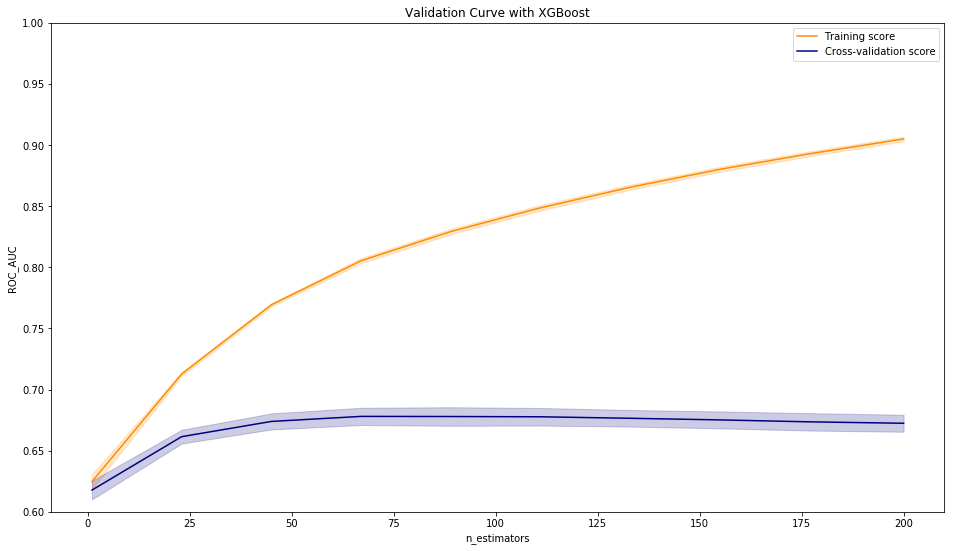

Best cross-validation result (0.68) obtained for 67 trees


In [317]:
# plotting
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(16, 9))
plt.title("Validation Curve with XGBoost")
plt.xlabel(r"n_estimators")
plt.ylabel("ROC_AUC")
plt.ylim(0.6, 1.0)

plt.plot(n_estimators_range, train_scores_mean, label="Training score",
             color="darkorange")
plt.plot(n_estimators_range, test_scores_mean, label="Cross-validation score",
             color="navy")
plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2,
                 color="darkorange")
plt.fill_between(n_estimators_range, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.2,
                 color="navy")
plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))

In [326]:
# cross validation on max_depth
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
# max_depth = 5 6 7 8 9 10
max_depth_range = np.linspace(5, 10, 6).astype('int')
start = time.time()
train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(learning_rate= 0.1, 
                    n_estimators=67, # 根据上面的cv结论
                   objective= 'binary:logistic',
                   booster='gbtree',
                   tree_method='auto',
                   gamma=0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
                   reg_lambda=2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                   subsample=0.7, # 随机采样训练样本
                   colsample_bytree=0.7, # 生成树时进行的列采样
                   min_child_weight=1, 
                    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
                    # 假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
                    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
                   verbosity=2,
                   seed=1000
                  ),
    train_features, train_data['label'],
    param_name = 'max_depth',
    param_range = max_depth_range,
    cv=cv,
    scoring='roc_auc',
    n_jobs=6,
    verbose=2
)
end = time.time()
print('The program took %s seconds.' % (end-start))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  60 | elapsed:  9.6min remaining:  9.6min


The program took 1126.4778690338135 seconds.


[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 18.8min finished


In [327]:
np.savez('model/xgboost_cross_validation_results_lr0.1_67n_1230.npz', 
         train_scores = train_scores,
         test_scores = test_scores,
         train_duration = '18.8min'
        )

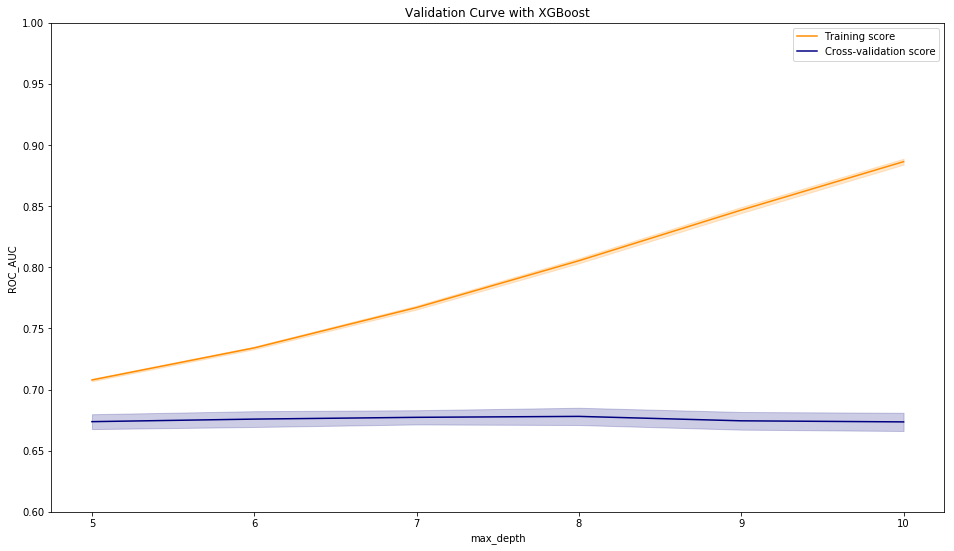

Best cross-validation result (0.68) obtained for 8 max_depth


In [329]:
# plotting
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(16, 9))
plt.title("Validation Curve with XGBoost")
plt.xlabel(r"max_depth")
plt.ylabel("ROC_AUC")
plt.ylim(0.6, 1.0)

plt.plot(max_depth_range, train_scores_mean, label="Training score",
             color="darkorange")
plt.plot(max_depth_range, test_scores_mean, label="Cross-validation score",
             color="navy")
plt.fill_between(max_depth_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2,
                 color="darkorange")
plt.fill_between(max_depth_range, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.2,
                 color="navy")
plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} max_depth".format(test_scores_mean[i], 
                                                                                 max_depth_range[i]))

In [336]:
# cross validation on learning_rate
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
# learning_rate = 0.1 0.2 0.3 0.4 0.5
# lr_range = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
lr_range = [0.5]
start = time.time()
train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(max_depth= 8, #根据上面的cv结论
                    n_estimators=67, # 根据上面的cv结论
                   objective= 'binary:logistic',
                   booster='gbtree',
                   tree_method='auto',
                   gamma=0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
                   reg_lambda=2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                   subsample=0.7, # 随机采样训练样本
                   colsample_bytree=0.7, # 生成树时进行的列采样
                   min_child_weight=1, 
                    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
                    # 假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
                    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
                   verbosity=2,
                   seed=1000
                  ),
    train_features, train_data['label'],
    param_name = 'learning_rate',
    param_range = lr_range,
    cv=cv,
    scoring='roc_auc',
    n_jobs=6,
    verbose=2
)
end = time.time()
print('The program took %s seconds.' % (end-start))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:  1.8min remaining:  1.8min


The program took 204.09365820884705 seconds.


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:  3.4min finished


In [332]:
np.savez('model/xgboost_cross_validation_results_8maxdepth_67n_1230.npz', 
         train_scores = train_scores,
         test_scores = test_scores,
         train_duration = ''
        )

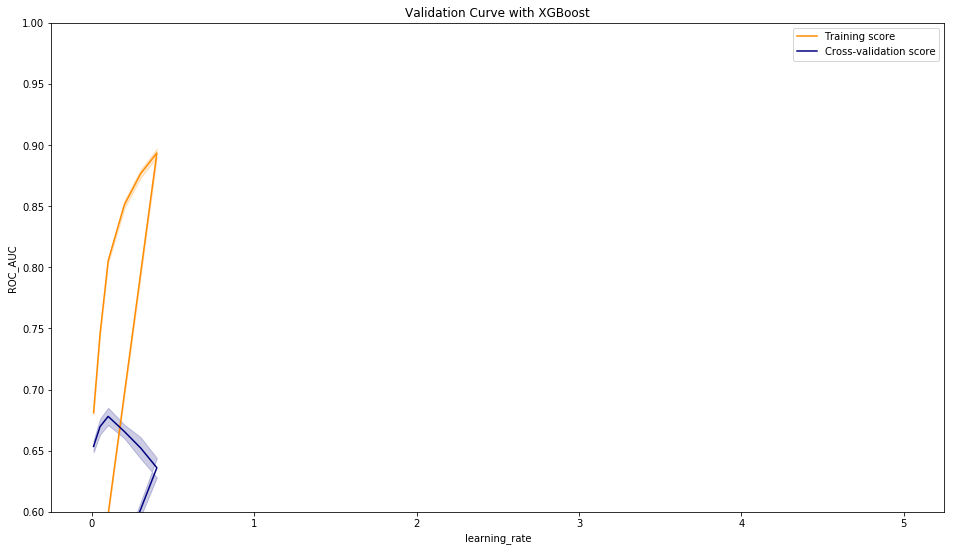

Best cross-validation result (0.68) obtained for 0.1 max_depth


In [333]:
# plotting
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(16, 9))
plt.title("Validation Curve with XGBoost")
plt.xlabel(r"learning_rate")
plt.ylabel("ROC_AUC")
plt.ylim(0.6, 1.0)

plt.plot(lr_range, train_scores_mean, label="Training score",
             color="darkorange")
plt.plot(lr_range, test_scores_mean, label="Cross-validation score",
             color="navy")
plt.fill_between(lr_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2,
                 color="darkorange")
plt.fill_between(lr_range, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.2,
                 color="navy")
plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} max_depth".format(test_scores_mean[i], 
                                                                                 lr_range[i]))

In [334]:
test_scores_mean

array([0.65356634, 0.66972497, 0.67808174, 0.66568732, 0.65226298,
       0.63608784, 0.5       , 0.5166081 ])

In [335]:
lr_range

[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0, 5]